## Lab 7 (Image Processing using Convolutional Neural Networks)
- CIFAR10 dataset (see https://www.cs.toronto.edu/~kriz/cifar.html for more info)
- 60K images: 50K train, 10K test
- 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Perform multi-class classification with evaluation accuracy on EACH class

**CONNECT TO GPU** before continuing, but just CPU is also fine, it might be a bit slow.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Q1. Why are there 3 values in each list of the Normalize() function? What does each value and each list represent?
# 3 values mean 3 channels
# first tuple means -> mean values of each color channel
# second tuple means -> standard deviation values of each color channer 

cuda


100%|██████████| 170498071/170498071 [00:17<00:00, 9607246.33it/s] 


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


### Inspect the Images

In [9]:
# Access the first data sample in the train_set using next(iter())
batch = next(iter(train_loader))
print(f'Image values: \n{batch}')
print(f'Length: {len(batch)}')
print(f'Type: {type(batch)}')

# This means the data contains image-label pairs
# Unpack them
images, labels = batch
# Same as these two lines:
# image = batch[0]
# label = batch[1]


print(images.shape)
print(labels)

# Q2. What is the range of the values for the normalised image pixels?
# -1 to 1
# Q3. What does each index value of the shape of the image represent?
# because batch size is 4, 4 images are gathered
# and each has 3 channels(color) and 32*32 pixels
# Q4. What do the label values represent?
# label values mean that answer type(class) of image

Image values: 
[tensor([[[[-0.0588, -0.0275, -0.0118,  ..., -0.1373, -0.1529, -0.1843],
          [-0.0039,  0.0039,  0.0118,  ..., -0.1137, -0.1216, -0.1608],
          [ 0.0431,  0.0510,  0.0667,  ..., -0.0902, -0.1059, -0.1294],
          ...,
          [ 0.1765,  0.1686,  0.1686,  ..., -0.8588, -0.8353, -0.7569],
          [ 0.1529,  0.1608,  0.1608,  ..., -0.6314, -0.7255, -0.8118],
          [ 0.1294,  0.1451,  0.1373,  ..., -0.0824, -0.4824, -0.8353]],

         [[ 0.2941,  0.3176,  0.3333,  ...,  0.1922,  0.1765,  0.1529],
          [ 0.3490,  0.3569,  0.3647,  ...,  0.2157,  0.2157,  0.1922],
          [ 0.3961,  0.4039,  0.4196,  ...,  0.2627,  0.2471,  0.2235],
          ...,
          [ 0.2000,  0.1922,  0.2000,  ..., -0.8431, -0.8196, -0.7490],
          [ 0.1765,  0.1843,  0.1843,  ..., -0.6078, -0.6941, -0.7961],
          [ 0.1529,  0.1686,  0.1608,  ..., -0.0745, -0.4510, -0.8196]],

         [[ 0.7647,  0.7961,  0.8039,  ...,  0.6471,  0.6314,  0.6000],
          [ 0.

### View some images
- Note that images have been normalised and may not look very clear

class labels: tensor([9, 2, 5, 0])


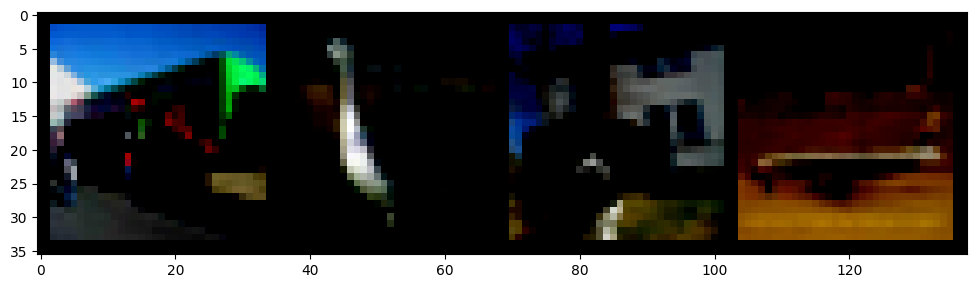

In [10]:
# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

## CNN model

In [11]:
class Test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5, padding=1) # in channel 3, out channel 6, kerner size 5
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2) # kernel size = 2 stride = 2
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # Q8. Fill out the correct input dimensions 
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    print(f'Input shape: {x.shape}') # 4 3 32 32
    out = self.conv1(x) 
    print(f'After Conv1: {out.shape}') # 4 6 28 28
    print(f'Padding: {self.conv1.padding}')
    out = self.pool(F.relu(out))
    print(f'After Pool1: {out.shape}') # 4 6 14 14
    out = self.conv2(out)
    print(f'After Conv2: {out.shape}') # 4 16 10 10
    out = self.pool(F.relu(out))
    print(f'After Pool2: {out.shape}') # 4 16 5 5
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # Q8. Fill out the correct dimension after -1
    print(f'Before fc1: {out.shape}') # 4 400(16*5*5)
    out = self.fc1(out)
    out = self.relu(out)
    print(f'After fc1: {out.shape}') # 4 124
    out = self.fc2(out)
    out = self.relu(out)
    print(f'After fc2: {out.shape}') # 4 64
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    print(f'After fc3: {out.shape}') # 4 10
    return out


model = Test().to(device)
# Let's view the softmax output
probs = nn.Softmax(dim=1)


# Q5. What do the three arguments of the first convolutional layer, conv1 represent (3,6,5)? 
# in_channel is 3, out_channel is 6 and kernel_size(filter) is 5
# Q6. Explain the arguments of the second convolutional layer, conv2 (6, 16, 5) 
# in_channel is 6, out_channel is 16 and kernel_size is 5.
# also could mean that 6 filters used at first conv layer
# Q7. Figure out the convolved image size after conv1
# Convolved image size = ((input_width - filter_size + 2 * padding) / stride) + 1
# input_width=32 filter_size=5 padding=0 stride=1
# ((32 - 5 + 2*0)/1) + 1 = 17/1 + 1 = 18
# Q8. Figure out the input size to the first fcn layer and fill out the code above in init() and forward()
# after conv1&pool1 -> 4 6 14 14 / after conv2&pool2 -> 4 16 5 5

### Run through a sample batch

In [12]:
sample = next(iter(train_loader))

images, labels = sample

images = images.to(device)
labels = labels.to(device)

output = model(images)
print(f'Output shape: {output.shape}')
print(f'Softmax outputs:\n {probs(output)}')


# Q9. Explain the shape of the output after conv1
# channel size is incresed 3 to 6, and size of image is decreased 32*32 to 28*28
# Q10. What does the pooling do to the dimensions of the feature images here?
# pooling makes each dimension halves
# Q11. Add padding=1 to conv1 and rerun the last two code cells. How did padding affect the dimensions of the feature images?
# padding affects dimensions of feachers image less be shrinks (similar much with before conv layer than without padding)
# Q12. What is represented by each list returned by Softmax outputs?
# each list returns probability of each class

Input shape: torch.Size([4, 3, 32, 32])
After Conv1: torch.Size([4, 6, 30, 30])
Padding: (1, 1)
After Pool1: torch.Size([4, 6, 15, 15])
After Conv2: torch.Size([4, 16, 11, 11])
After Pool2: torch.Size([4, 16, 5, 5])
Before fc1: torch.Size([4, 400])
After fc1: torch.Size([4, 128])
After fc2: torch.Size([4, 64])
After fc3: torch.Size([4, 10])
Output shape: torch.Size([4, 10])
Softmax outputs:
 tensor([[0.0963, 0.0967, 0.1104, 0.0996, 0.1055, 0.0879, 0.0952, 0.1090, 0.1069,
         0.0925],
        [0.0959, 0.0964, 0.1103, 0.0996, 0.1052, 0.0882, 0.0971, 0.1077, 0.1068,
         0.0928],
        [0.0977, 0.0968, 0.1097, 0.1006, 0.1038, 0.0874, 0.0959, 0.1082, 0.1071,
         0.0929],
        [0.0969, 0.0970, 0.1101, 0.0987, 0.1055, 0.0876, 0.0956, 0.1082, 0.1072,
         0.0932]], device='cuda:0', grad_fn=<SoftmaxBackward0>)



### Let's Train!
- Now that we know and understand how CNNs work, let's put everything together for CIFAR-10 dataset
  - Download the data in batches and normalisation with shuffling
  - Build a model with 2 CNN layers containing ReLU and pooling
  - Passing the feature images to 3 fully connected layers (FCNs) also containing RELU activation
  - The final layer has 10 units to reprsent the number of output classes
  - Use Binary Cross Entropy Loss and SGD optimiser
  - Evaluate the model on the test data on EACH class

**IMPORTANT!** Fill out the missing code below before training 

In [15]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss()

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Training loop

In [16]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')



Epoch 1/4, Iteration 1000/12500, Loss=2.2472 
Epoch 1/4, Iteration 2000/12500, Loss=2.2059 
Epoch 1/4, Iteration 3000/12500, Loss=1.7338 
Epoch 1/4, Iteration 4000/12500, Loss=1.9632 
Epoch 1/4, Iteration 5000/12500, Loss=1.8694 
Epoch 1/4, Iteration 6000/12500, Loss=1.1912 
Epoch 1/4, Iteration 7000/12500, Loss=2.5669 
Epoch 1/4, Iteration 8000/12500, Loss=1.6138 
Epoch 1/4, Iteration 9000/12500, Loss=2.4875 
Epoch 1/4, Iteration 10000/12500, Loss=1.3317 
Epoch 1/4, Iteration 11000/12500, Loss=1.8757 
Epoch 1/4, Iteration 12000/12500, Loss=2.0767 
Epoch 2/4, Iteration 1000/12500, Loss=2.3849 
Epoch 2/4, Iteration 2000/12500, Loss=2.0113 
Epoch 2/4, Iteration 3000/12500, Loss=0.4467 
Epoch 2/4, Iteration 4000/12500, Loss=1.7022 
Epoch 2/4, Iteration 5000/12500, Loss=1.6079 
Epoch 2/4, Iteration 6000/12500, Loss=0.5530 
Epoch 2/4, Iteration 7000/12500, Loss=2.6210 
Epoch 2/4, Iteration 8000/12500, Loss=1.1665 
Epoch 2/4, Iteration 9000/12500, Loss=1.3489 
Epoch 2/4, Iteration 10000/1250

## Evaluation

In [17]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 60.19 %
Accuracy of plane: 66.9 %
Accuracy of car: 78.1 %
Accuracy of bird: 28.8 %
Accuracy of cat: 32.9 %
Accuracy of deer: 54.2 %
Accuracy of dog: 68.8 %
Accuracy of frog: 67.4 %
Accuracy of horse: 71.2 %
Accuracy of ship: 69.5 %
Accuracy of truck: 64.1 %


In [ ]:
# Q15. Why don't we need to reshape the input images when training and testing?
# because images are not fed into FC at first. keep spatial information
# Q16. Try to improve the model performance, e.g. by increasing the epochs, changing batch size, adding convolutions, etc.
# Provide the code chunk showing the improved accuracy on the test set below. What changes did you make?
# learning_rate 0.001 to 0.0001 and num_epochs 4 to 10

In [22]:
# hyperparameters
learning_late = 0.0001
num_epochs = 10

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16*5*5, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) 

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = out.reshape(-1, 16*5*5)
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) 
    return out


model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')
  print()

Epoch 1/10, Iteration 1000/12500, Loss=2.3111 
Epoch 1/10, Iteration 2000/12500, Loss=1.8769 
Epoch 1/10, Iteration 3000/12500, Loss=2.2419 
Epoch 1/10, Iteration 4000/12500, Loss=2.0824 
Epoch 1/10, Iteration 5000/12500, Loss=0.7872 
Epoch 1/10, Iteration 6000/12500, Loss=1.8881 
Epoch 1/10, Iteration 7000/12500, Loss=1.8027 
Epoch 1/10, Iteration 8000/12500, Loss=1.3564 
Epoch 1/10, Iteration 9000/12500, Loss=0.9522 
Epoch 1/10, Iteration 10000/12500, Loss=0.6289 
Epoch 1/10, Iteration 11000/12500, Loss=1.1394 
Epoch 1/10, Iteration 12000/12500, Loss=0.5076 

Epoch 2/10, Iteration 1000/12500, Loss=1.5262 
Epoch 2/10, Iteration 2000/12500, Loss=1.5547 
Epoch 2/10, Iteration 3000/12500, Loss=1.5889 
Epoch 2/10, Iteration 4000/12500, Loss=1.5926 
Epoch 2/10, Iteration 5000/12500, Loss=2.5068 
Epoch 2/10, Iteration 6000/12500, Loss=0.5545 
Epoch 2/10, Iteration 7000/12500, Loss=0.9590 
Epoch 2/10, Iteration 8000/12500, Loss=0.7270 
Epoch 2/10, Iteration 9000/12500, Loss=0.9603 
Epoch 2/1

In [23]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Test Accuracy of the WHOLE CNN = 61.76 %
Accuracy of plane: 70.8 %
Accuracy of car: 72.6 %
Accuracy of bird: 40.7 %
Accuracy of cat: 50.2 %
Accuracy of deer: 53.3 %
Accuracy of dog: 45.1 %
Accuracy of frog: 67.1 %
Accuracy of horse: 76.1 %
Accuracy of ship: 81.9 %
Accuracy of truck: 59.8 %
